In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import *
from fastai.callbacks import *

#Para rodar no meu pc a VM Instance
#gcloud compute ssh jupyter@my-fastai-instance -- -L 8080:localhost:8080

# Testar to_fp16, size diferente, ir fazendo transfer learning de sizes diferentes, fine_tunning, wd diferente

# DATA

### Dataset

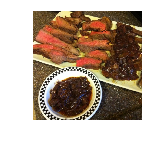

In [3]:
path = './food-101'
path_anno = path + '/meta'
path_img = path + '/images'

np.random.seed(2) #mesma semente para todas as vezes que executar

fnames = get_image_files(path_img + '/steak')
fnames[:3]

img = open_image(fnames[0])
img.show(figsize=(2,2))

In [4]:
# test = np.loadtxt(path_anno + '/test.txt', dtype=str)
# cont = 0
# for item in test:
#     item = item + '.jpg'
#     test[cont] = item
#     cont+=1
# np.savetxt(path_anno + '/testJPG.txt', test, fmt="%s")

In [5]:
# free = gpu_mem_get_free_no_cache()
# # the max size of bs depends on the available GPU RAM
# if free > 8200: bs=8
# else:           bs=4
# print(f"using bs={bs}, have {free}MB of GPU RAM free")

bs = 32 # batch size
size = 320 # image size

### Transformations

In [6]:
# tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
tfms = get_transforms()

### DataBunch

In [7]:
data = (ImageList.from_folder(path_img) #Where to find the data? -> in path and its subfolders
        #.split_by_rand_pct()
        .split_by_fname_file('../meta/testJPG.txt')  #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        #.add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=size)     #Data augmentation? -> use tfms with a size of 64
        .databunch(bs=bs)
        .normalize(imagenet_stats))


In [8]:
data.c, len(data.train_ds), len(data.valid_ds)

(101, 76555, 24445)

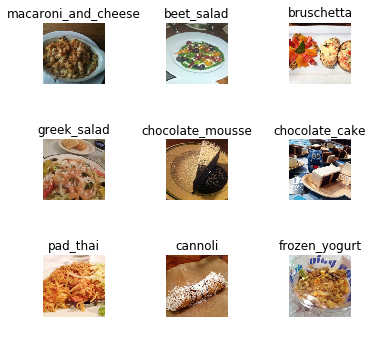

In [9]:
data.show_batch(3, figsize=(5,5), ds_type=DatasetType.Train)

# TRAINING 

In [18]:
precision = Precision()
recall = Recall()
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy, precision, recall], callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


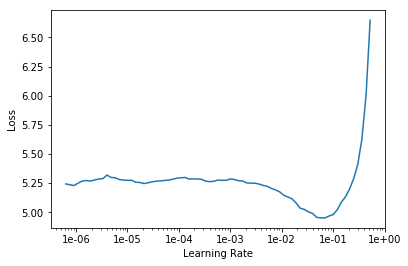

In [11]:
lr_find(learn)
learn.recorder.plot()

In [21]:
lr = 1e-2

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,1.392279,0.859851,0.237349,0.762651,0.756632,nan,12:52
1,1.697254,1.196349,0.325302,0.674698,0.700922,nan,12:57
2,1.913751,1.569392,0.425977,0.574023,0.665890,nan,12:56
3,1.972075,1.296929,0.352342,0.647658,0.664772,nan,12:57
4,1.819686,1.235256,0.340233,0.659767,0.685541,nan,12:56
5,1.694582,1.094674,0.300061,0.699939,0.709536,nan,12:56
6,1.605309,0.964462,0.265044,0.734956,0.731546,nan,12:55
7,1.356120,0.853931,0.235958,0.764042,0.758230,nan,12:55
8,1.227988,0.794155,0.216731,0.783269,0.771684,nan,12:55
9,1.224500,0.784657,0.215463,0.784537,0.772932,nan,12:54


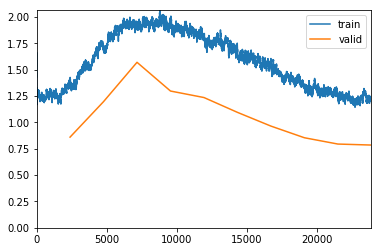

Better model found at epoch 0 with accuracy value: 0.7626508474349976.
Better model found at epoch 7 with accuracy value: 0.7640417218208313.
Better model found at epoch 8 with accuracy value: 0.7832685708999634.
Better model found at epoch 9 with accuracy value: 0.7845367193222046.


PosixPath('food-101/images/models/stage-1-320size-10epochs-resnet34.pth')

In [22]:
learn.fit_one_cycle(10, lr,
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy',
                                                 name='stage-1-320size-10epochs-resnet34')]) 
learn.save('stage-1-320size-10epochs-resnet34',return_path=True)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,1.857167,1.305861,0.353201,0.646799,0.687405,nan,12:52
1,1.393736,0.873237,0.237308,0.762692,0.752040,nan,12:56


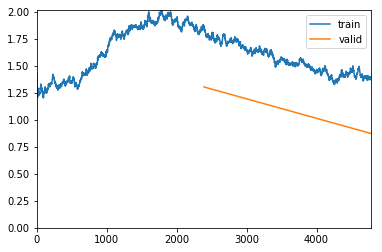

Better model found at epoch 0 with accuracy value: 0.6467989087104797.
Better model found at epoch 1 with accuracy value: 0.7626917362213135.


In [25]:
learn.fit_one_cycle(2, lr,
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy',
                                                 name='stage-1-best')]) 


In [26]:
learn.load('stage-1-best')
learn.save('stage-1-320size-bestEpoch-resnet34')

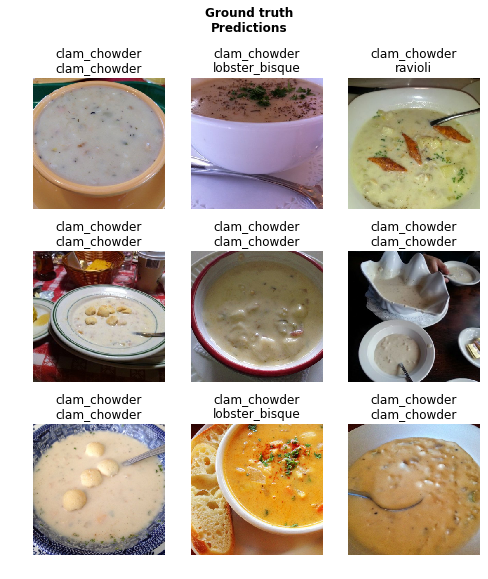

In [27]:
learn.show_results(rows=3, figsize=(8,9))

# INTERPRETATION

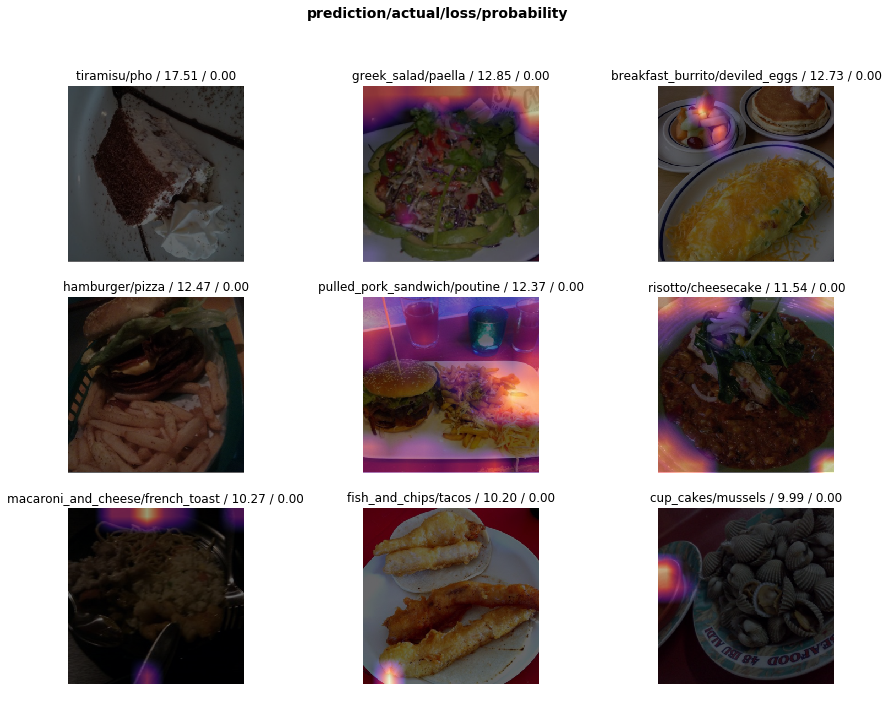

In [28]:
precision = Precision()
recall = Recall()
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy, precision, recall])
learn.load('stage-1-320size-bestEpoch-resnet34')
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))


In [30]:
interp.most_confused(min_val=20)

[('steak', 'filet_mignon', 45),
 ('filet_mignon', 'steak', 29),
 ('hamburger', 'pulled_pork_sandwich', 26),
 ('pork_chop', 'grilled_salmon', 25),
 ('chocolate_mousse', 'chocolate_cake', 24),
 ('club_sandwich', 'grilled_cheese_sandwich', 23),
 ('beef_tartare', 'tuna_tartare', 22),
 ('tuna_tartare', 'beef_tartare', 21)]

# FINE-TUNING

In [31]:
precision = Precision()
recall = Recall()
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy, precision, recall],
                    callback_fns=ShowGraph).to_fp16()
learn.load('stage-1-320size-bestEpoch-resnet34')
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


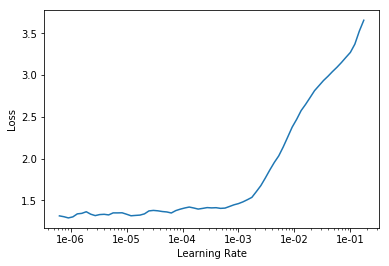

In [32]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,1.308777,0.856042,0.232072,0.767928,0.757007,nan,15:50
1,1.350245,0.837353,0.229004,0.770996,0.759456,nan,15:57
2,1.256375,0.807388,0.219840,0.780160,0.769561,nan,15:58
3,1.230601,0.777138,0.212518,0.787482,0.777047,nan,15:57
4,1.179882,0.744128,0.204459,0.795541,0.784455,nan,15:53
5,1.087912,0.717163,0.197055,0.802945,0.791064,nan,15:56
6,1.100483,0.696558,0.191532,0.808468,0.797861,nan,15:56
7,0.996238,0.673732,0.185069,0.814931,0.803670,nan,15:56
8,0.991982,0.661570,0.183064,0.816936,0.805749,nan,15:54
9,0.959723,0.646105,0.179505,0.820495,0.809303,nan,15:54


/opt/anaconda3/lib/python3.7/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


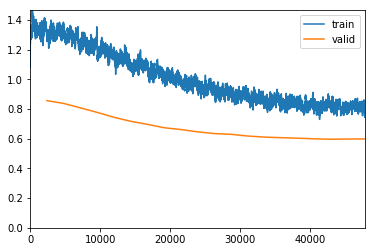

Better model found at epoch 0 with accuracy value: 0.7679280042648315.
Better model found at epoch 1 with accuracy value: 0.77099609375.
Better model found at epoch 2 with accuracy value: 0.7801595330238342.
Better model found at epoch 3 with accuracy value: 0.7874820828437805.
Better model found at epoch 4 with accuracy value: 0.795540988445282.
Better model found at epoch 5 with accuracy value: 0.8029453754425049.
Better model found at epoch 6 with accuracy value: 0.8084679841995239.
Better model found at epoch 7 with accuracy value: 0.8149314522743225.
Better model found at epoch 8 with accuracy value: 0.8169359564781189.
Better model found at epoch 9 with accuracy value: 0.8204950094223022.
Better model found at epoch 10 with accuracy value: 0.8231949210166931.
Better model found at epoch 11 with accuracy value: 0.8268766403198242.
Better model found at epoch 12 with accuracy value: 0.8283493518829346.
Better model found at epoch 13 with accuracy value: 0.831417441368103.
Better mo

In [36]:
learn.fit_one_cycle(20, max_lr=slice(1e-6,1e-4),
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy',
                                                 name='stage-2-best')])

In [37]:
learn.load('stage-2-best')
learn.save('stage-2-320size-bestEpoch-resnet34', return_path=True)

PosixPath('food-101/images/models/stage-2-320size-bestEpoch-resnet34.pth')

In [48]:
precision = Precision()
recall = Recall()
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy, precision, recall], wd=1e-3,
                    callback_fns=ShowGraph).to_fp16()
learn.load('stage-2-320size-bestEpoch-resnet34');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


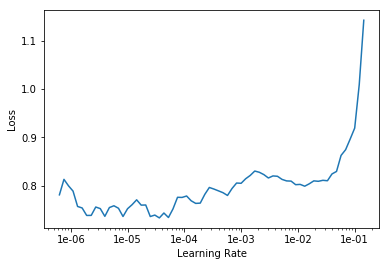

In [44]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.861083,0.624757,0.174351,0.825649,0.814204,nan,12:22


/opt/anaconda3/lib/python3.7/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


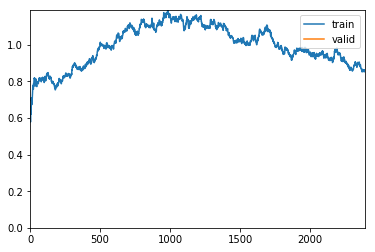

Better model found at epoch 0 with accuracy value: 0.8256494402885437.


In [49]:
learn.fit_one_cycle(1, max_lr=slice(1e-4,1e-2),
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy',
                                                 name='stage-2-best')])

In [ ]:
#save model to use in unet learner
encoder_path = path + '/resnet34_encoder-food101.h5'
torch.save(learn.model[0].state_dict(), encoder_path)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
losses,idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.most_confused(min_val=10)